## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
# import matplotlib.pyplot as plt
# %matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i ==0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units,
                             activation='softmax',
                             name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer],
                               outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE=[10, 25]

In [15]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping
def earlystop(exp):
    return EarlyStopping(monitor='val_accuracy',patience=exp,verbose=1)


results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for patience in PATIENCE:
    keras.backend.clear_session()
    print('The patience as {}'.format(patience))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE,
                                     nesterov=True,
                                     momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=optimizer)
    model.fit(x_train, y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[earlystop(patience)])
    
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['accuracy']
    valid_acc = model.history.history['val_accuracy']
    
    exp_name_tag = 'patience {}'.format(patience)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc' : train_acc,
                             'valid-acc' : valid_acc}

The patience as 10
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)

50000/50000 [==============================] - 5s 91us/step - loss: 2.1743 - accuracy: 0.2750 - val_loss: 2.1241 - val_accuracy: 0.2315
Epoch 2/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.7427 - accuracy: 0.3938 - val_loss: 1.9521 - val_accuracy: 0.3089
Epoch 3/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.6223 - accuracy: 0.4311 - val_loss: 1.8495 - val_accuracy: 0.3609
Epoch 4/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.5502 - accuracy: 0.4554 - val_loss: 1.7416 - val_accuracy: 0.3889
Epoch 5/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.4936 - accuracy: 0.4754 - val_loss: 1.6492 - val_accuracy: 0.4205
Epoch 6/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.4471 - accuracy: 0.4920 - val_loss: 1.5932 - val_accuracy: 0.4349
Epoch 7/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.4079 - accuracy: 0.5060 - val_loss: 1.5581 - val

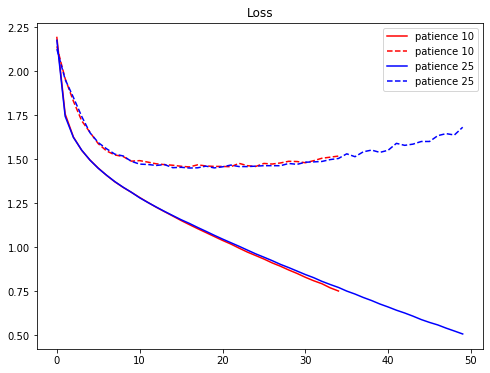

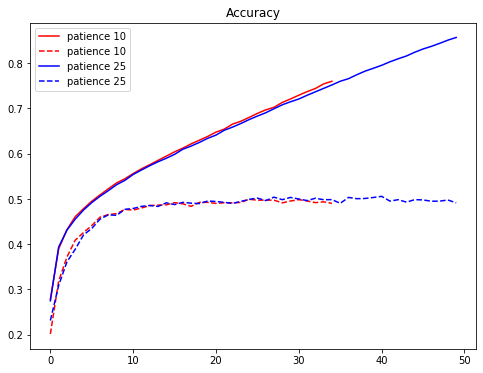

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color = ['r', 'b']

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label=cond, color=color[i])
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], '--', label=cond, color=color[i])
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], '-', label=cond, color=color[i])
    plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], '--', label=cond, color=color[i])
plt.title('Accuracy')
plt.legend()
plt.show()
    